In [86]:
# Do we have enough tracks here? Or will we get push back?
# Need some statistical significance on the profiles
# How many tracks can we actually get in the Weddell? How much of a subset is this?
# Can we plot these tracks on to a Weddell map, to get a sense of their spatial distributions?

In [92]:
import os
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
import time


In [93]:
# Functions 

def dist(lon1,lat1,lon2,lat2):
  lon1_rad = np.radians(lon1)
  lon2_rad = np.radians(lon2)
  lat1_rad = np.radians(lat1)
  lat2_rad = np.radians(lat2)
  #Assumes degrees input
  #Calculates in metres
  R = 6371000 #Radius of earth in metres (roughly)
  ## Uses Haversine formula
  a1 = (sin((lat2_rad-lat1_rad)/2))**2
  a2 = (cos(lat1_rad))*(cos(lat2_rad))*((sin((lon2_rad-lon1_rad)/2))**2)
  a = a1 + a2
  c = 2*atan2(sqrt(a),sqrt(1-a))
  d = R*c
  return d

def get_floes(ice_leads_msk,fb_height,seg_dist_x,rprof):
    nfloes_max = int(np.floor(len(ice_leads_msk)/2)) # Estimated max number of floes (to make big enough arrays)
    floe_chord_lengths = np.zeros(nfloes_max) 
    floe_fb = np.zeros(nfloes_max) 
    floe_profiles = np.zeros((nprof,nfloes_max))
    ice_cnt_st = 0
    ice_cnt_en = 0
    floe_idx = 1
    for i in range(1,len(ice_leads_msk)):
        if (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 0): # start floe
            ice_cnt_st = i
            ice_cnt_en = i
        elif (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 1): # grow floe
            ice_cnt_en += 1
        elif (ice_leads_msk[i-1] == 1) and (ice_leads_msk[i] == 0): # stop floe
            floe_chord_lengths[floe_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
            floe_fb[floe_idx] = np.mean(fb_height[ice_cnt_st:ice_cnt_en+1]) 
            #
            prof = fb_height[ice_cnt_st:ice_cnt_en+1]
            xx_prof = np.linspace(0,1,ice_cnt_en-ice_cnt_st+1)
            floe_profiles[:,floe_idx] = np.interp(rprof, xx_prof, prof)
            floe_idx += 1
    #        
    # Removing spurious floes (< 10m, > 10 km, fb < 0.1)
    remove_idx = np.where(floe_chord_lengths < 10)[0]  
    remove_idx = np.append(remove_idx,np.where(floe_chord_lengths > 10e3)[0])
    remove_idx = np.append(remove_idx,np.where(floe_fb < 0.1)[0])
    floe_fb = np.delete(floe_fb,remove_idx)
    floe_chord_lengths = np.delete(floe_chord_lengths,remove_idx)
    floe_profiles = np.delete(floe_profiles,remove_idx,axis=1)
    #
    return floe_chord_lengths, floe_fb, floe_profiles

def normalize_vector(v):
    vmin = np.amin(v)
    vmax = np.amax(v)
    return (v - vmin)  / (vmax - vmin)

def get_size_binned_profiles(floe_profiles,floe_chord_lengths,bin_ranges=[50, 500, 5000, 50000]):
    half_idx = int(np.shape(floe_profiles)[0]/2) # index of halfway point across the floe profile
    nbins = len(bin_ranges) - 1
    nr = np.shape(floe_profiles)[0]
    binned_profiles = np.zeros((nr,nbins))
    binned_profiles_std = np.zeros((nr,nbins))
    for i in range(nbins):
        idx1 = np.where( (floe_chord_lengths >= bin_ranges[i]) )[0]
        idx2 = np.where( (floe_chord_lengths < bin_ranges[i+1]) )[0] 
        idx = np.intersect1d(idx1, idx2)
        if idx.size != 0:
            fp = floe_profiles[:,idx]
            floe_profiles_norm = normalize_vector(fp)
            LHS = np.mean(floe_profiles_norm[0:half_idx],axis=1)
            RHS = np.mean(floe_profiles_norm[half_idx:],axis=1)
            full = normalize_vector(0.5*(LHS + np.flip(RHS))) 
            binned_profiles[:,i] = np.concatenate((full, np.flip(full)), axis=0) * np.mean(fp)
            
            LHS_std = np.std(floe_profiles_norm[0:half_idx],axis=1)
            RHS_std = np.std(floe_profiles_norm[half_idx:],axis=1)
            full_std = normalize_vector(0.5*(LHS_std + np.flip(RHS_std))) 
            binned_profiles_std[:,i] = np.concatenate((full_std, np.flip(full_std)), axis=0) * np.std(fp)
            
    return binned_profiles,binned_profiles_std
    

In [136]:
# Studying floe profiles

# MG: INCLUDE ERROR BARS ONTO FLOES CHORDS

###################### PATH TO DIRECTORY AND PREFIX: WILL USE ALL FILES IN HERE #############################
path = '/Users/heareg/Documents/Floes/working_directory/Ross_overlaps/'; titstr = 'Ross'; EWlon = 150; pref = 'ATL10'
path = '/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/'; titstr = 'Weddell'; EWlon = -50; pref = 'ATL10'

figdir = '/Users/heareg/Documents/Floes/working_directory/figures/overlapped_'
#############################################################################################################


filelist = [file for file in os.listdir(path) if file.endswith('.h5')]
nfiles = len(filelist)

if "Weddell" in path:
    lonlim1 = [-70,-5]
    lonlim2 = [-70,-5]
    latlim = [-85,-50]
elif "Ross" in path:
    lonlim1 = [-180,-140]
    lonlim2 = [160,180]
    latlim = [-85,-50]
else:
    print('error: region not recognised')
    
# Initializing bin ranges
nn = 10
floe_chord_bin_ranges = []
for i in range(3):
    st = 10**(i+1)
    en = 10**(i+2) 
    stp = 2*10**(i)
    floe_chord_bin_ranges = np.append(floe_chord_bin_ranges,np.arange(st,en,stp))
floe_chord_bin_means = 0.5*(floe_chord_bin_ranges[0:-1] + floe_chord_bin_ranges[1:])
nbins_chords = len(floe_chord_bin_means)

# Floe profile parameters 
nprof = 50 # number of points in normalized profiles
rprof = np.linspace(0,1,nprof)

# # Looping through h5 files in directory
floe_chord_lengths = []
floe_fb = []
floe_profiles = []
floe_years_prof = []
floe_months_prof = []
floe_days_prof = []
floe_years_fb = []
floe_months_fb = []
floe_days_fb = []

floe_chord_lengths_W = []
floe_fb_W = []
floe_profiles_W = []
floe_years_prof_W = []
floe_months_prof_W = []
floe_days_prof_W = []
floe_years_fb_W = []
floe_months_fb_W = []
floe_days_fb_W = []

floe_chord_lengths_E = []
floe_fb_E = []
floe_profiles_E = []
floe_years_prof_E = []
floe_months_prof_E = []
floe_days_prof_E = []
floe_years_fb_E = []
floe_months_fb_E = []
floe_days_fb_E = []

cnt_file = 0
for fname in filelist:
  if fname[0:5] == 'ATL10':
    this_ATL10=h5py.File(path+fname, 'r')
    print(fname)
    
    # Getting strong beams 
    orient = this_ATL10['orbit_info/sc_orient'][0]
    if orient==0:
        strong_beams = ['gt1l','gt2l','gt3l']
    elif orient==1:
        strong_beams = ['gt1r','gt2r','gt3r']
    else:
        strong_beams = []
    
    # Looping over strong beams
    for beam in strong_beams:  
        # Getting data
        fb_height = np.array(np.squeeze(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/beam_fb_height'])) 
        fb_lat = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/latitude'])
        fb_lon = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/longitude'])
        height_segment_ssh_flag = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_ssh_flag'])
        seg_dist_x = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/seg_dist_x'])
        height_segment_type = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_type'])
        
        ##### IS THIS CHECK NECESSARY??
        fb_height[fb_height > 30] = 0
        
        #
        beam_lead_n = this_ATL10[beam+'/freeboard_beam_segment/beam_lead_n']
        ref_height = this_ATL10[beam+'/freeboard_beam_segment/beam_refsurf_alongtrack_slope']
        ice_conc = this_ATL10[beam+'/freeboard_beam_segment/height_segments/ice_conc']
        lead_height = this_ATL10[beam+'/leads/lead_height']
        lead_length = this_ATL10[beam+'/leads/lead_length']
        lead_lat = this_ATL10[beam+'/leads/latitude']
        lead_lon = this_ATL10[beam+'/leads/longitude']

        ### for some reason, there  are pointns from other regions. Restrict by lonlim1 and lonlim2, and add to spurious mask
        lonmask = np.zeros(np.shape(fb_lon))
        lonmask[(fb_lon>=lonlim1[0])&(fb_lon<=lonlim1[1])] = 1
        lonmask[(fb_lon>=lonlim2[0])&(fb_lon<=lonlim2[1])] = 1
        
        lonmask_W = lonmask*1; lonmask_W[fb_lon>EWlon] = 0
        lonmask_E = lonmask*1; lonmask_E[fb_lon<=EWlon] = 0
        
        # Making a mask for spurious values
        npoints = len(fb_height)
        spurious_msk = np.ones(npoints)
        spurious_msk[fb_height>1e38] = 0
        #
        delta_seg_dist_x = np.append(0,np.diff(seg_dist_x)) 
        spurious_msk[delta_seg_dist_x > 500] = 0
        # 
        spurious_msk[np.isnan(fb_height)] = 0
        #
        spurious_msk[fb_height<0.05] = 0
        
        spurious_msk_E = spurious_msk*1
        spurious_msk_W = spurious_msk*1
        
        spurious_msk[lonmask==0] = 0
        spurious_msk_E[lonmask_E==0] = 0
        spurious_msk_W[lonmask_W==0] = 0
        
        # Creating binary array for: leads or spurious (0) / ice (1)
        ice_leads_msk = np.array(height_segment_type)
        ### flag_meanings : 
        # 0: cloud_covered 
        # 1: other
        # 2: specular_lead_low_w_bkg 
        # 3: specular_lead_low
        # 4: specular_lead_high_w_bkg 
        # 5: specular_lead_high
        # 6: dark_lead_smooth_w_bkg 
        # 7: dark_lead_smooth
        # 8: dark_lead_rough_w_bkg 
        # 9: dark_lead_rough
        ice_leads_msk[ice_leads_msk < 2] = 0
        ice_leads_msk[ice_leads_msk > 4] = 0
        ice_leads_msk[(ice_leads_msk <= 4)*(ice_leads_msk >= 2)] = 1
        
        ice_leads_msk_W = ice_leads_msk*1
        ice_leads_msk_E = ice_leads_msk*1
        
        ice_leads_msk = ice_leads_msk*spurious_msk
        ice_leads_msk = 1 - ice_leads_msk

        ice_leads_msk_E = ice_leads_msk_E*spurious_msk_E
        ice_leads_msk_E = 1 - ice_leads_msk_E
        
        ice_leads_msk_W = ice_leads_msk_W*spurious_msk_W
        ice_leads_msk_W = 1 - ice_leads_msk_W
        
        if pref == 'ATL10':
            yrange = [9,13]; mrange = [13,15]; drange = [15,17]
        elif pref == 'proce':
            yrange = [19,23]; mrange = [23,25]; drange = [25,27]
        else:
            print('error')
            
        # Getting floes
        floe_chord_lengths_tmp, floe_fb_tmp, floe_profiles_tmp = get_floes(ice_leads_msk,fb_height,seg_dist_x,rprof)
        
        # Appending to across-beam vectors
        floe_chord_lengths = np.append(floe_chord_lengths,floe_chord_lengths_tmp)
        floe_fb = np.append(floe_fb,floe_fb_tmp)
        floe_profiles = np.append(floe_profiles,np.ndarray.flatten(floe_profiles_tmp,order='F'),axis=0)
    
        this_y = int(fname[yrange[0]:yrange[1]])*np.ones(np.shape(floe_profiles_tmp))
        floe_years_prof = np.append(floe_years_prof,this_y)
        this_m = int(fname[mrange[0]:mrange[1]])*np.ones(np.shape(floe_profiles_tmp))
        floe_months_prof = np.append(floe_months_prof,this_m)
        this_d = int(fname[drange[0]:drange[1]])*np.ones(np.shape(floe_profiles_tmp))
        floe_days_prof = np.append(floe_days_prof,this_d)

        this_y = int(fname[yrange[0]:yrange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_years_fb = np.append(floe_years_fb ,this_y)
        this_m = int(fname[mrange[0]:mrange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_months_fb = np.append(floe_months_fb ,this_m)
        this_d = int(fname[drange[0]:drange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_days_fb = np.append(floe_days_fb ,this_d)
        
        #### Now additionally get for west and east
        
        ### West
        floe_chord_lengths_tmp, floe_fb_tmp, floe_profiles_tmp = get_floes(ice_leads_msk_W,fb_height,seg_dist_x,rprof)
        
        # Appending to across-beam vectors
        floe_chord_lengths_W = np.append(floe_chord_lengths_W,floe_chord_lengths_tmp)
        floe_fb_W = np.append(floe_fb_W,floe_fb_tmp)
        floe_profiles_W = np.append(floe_profiles_W,np.ndarray.flatten(floe_profiles_tmp,order='F'),axis=0)
    
        this_y = int(fname[yrange[0]:yrange[1]])*np.ones(np.shape(floe_profiles_tmp))
        floe_years_prof_W = np.append(floe_years_prof_W,this_y)
        this_m = int(fname[mrange[0]:mrange[1]])*np.ones(np.shape(floe_profiles_tmp))
        floe_months_prof_W = np.append(floe_months_prof_W,this_m)
        this_d = int(fname[drange[0]:drange[1]])*np.ones(np.shape(floe_profiles_tmp))
        floe_days_prof_W = np.append(floe_days_prof_W,this_d)

        this_y = int(fname[yrange[0]:yrange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_years_fb_W = np.append(floe_years_fb_W ,this_y)
        this_m = int(fname[mrange[0]:mrange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_months_fb_W = np.append(floe_months_fb_W ,this_m)
        this_d = int(fname[drange[0]:drange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_days_fb_W = np.append(floe_days_fb_W ,this_d)
        
        ### East
        floe_chord_lengths_tmp, floe_fb_tmp, floe_profiles_tmp = get_floes(ice_leads_msk_E,fb_height,seg_dist_x,rprof)
        
        # Appending to across-beam vectors
        floe_chord_lengths_E = np.append(floe_chord_lengths_E,floe_chord_lengths_tmp)
        floe_fb_E = np.append(floe_fb_E,floe_fb_tmp)
        floe_profiles_E = np.append(floe_profiles_E,np.ndarray.flatten(floe_profiles_tmp,order='F'),axis=0)
    
        this_y = int(fname[yrange[0]:yrange[1]])*np.ones(np.shape(floe_profiles_tmp))
        floe_years_prof_E = np.append(floe_years_prof_E,this_y)
        this_m = int(fname[mrange[0]:mrange[1]])*np.ones(np.shape(floe_profiles_tmp))
        floe_months_prof_E = np.append(floe_months_prof_E,this_m)
        this_d = int(fname[drange[0]:drange[1]])*np.ones(np.shape(floe_profiles_tmp))
        floe_days_prof_E = np.append(floe_days_prof_E,this_d)

        this_y = int(fname[yrange[0]:yrange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_years_fb_E = np.append(floe_years_fb_E ,this_y)
        this_m = int(fname[mrange[0]:mrange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_months_fb_E = np.append(floe_months_fb_E ,this_m)
        this_d = int(fname[drange[0]:drange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_days_fb_E = np.append(floe_days_fb_E ,this_d)
        
        
    cnt_file += 1
    

floe_profiles_orig = floe_profiles*1
floe_profiles_W_orig = floe_profiles_W*1
floe_profiles_E_orig = floe_profiles_E*1
print(np.shape(floe_profiles))
print(np.shape(floe_months_prof))

n1 = 50
n2 = int(len(floe_profiles)/n1)    
floe_profiles = np.transpose(np.reshape(floe_profiles,(n2,n1)) )      
 
binned_profiles,binned_profiles_std = get_size_binned_profiles(floe_profiles,floe_chord_lengths)

n1 = 50
n2 = int(len(floe_profiles_W)/n1)    
floe_profiles_W = np.transpose(np.reshape(floe_profiles_W,(n2,n1)) )      
 
binned_profiles_W,binned_profiles_std_W = get_size_binned_profiles(floe_profiles_W,floe_chord_lengths_W)

n1 = 50
n2 = int(len(floe_profiles_E)/n1)    
floe_profiles_E = np.transpose(np.reshape(floe_profiles_E,(n2,n1)) )      
 
binned_profiles_E,binned_profiles_std_E = get_size_binned_profiles(floe_profiles_E,floe_chord_lengths_E)

ATL10-02_20210203133757_06351001_005_01.h5
ATL10-02_20191208090337_11070501_005_02.h5
ATL10-02_20191025090101_04350501_005_02.h5
ATL10-02_20190301114641_09630201_005_02.h5
ATL10-02_20211030132017_05821301_005_01.h5
ATL10-02_20190317111321_12070201_005_02.h5
ATL10-02_20211014135334_03381301_005_01.h5
ATL10-02_20210303110522_10611001_005_01.h5
ATL10-02_20191031093538_05270501_005_02.h5
ATL10-02_20191005125113_01320501_005_02.h5
ATL10-02_20190905113210_10600401_005_02.h5
ATL10-02_20211103100324_06411301_005_01.h5
ATL10-02_20191002105936_00850501_005_02.h5
ATL10-02_20191104092718_05880501_005_02.h5
ATL10-02_20191013123433_02540501_005_02.h5
ATL10-02_20211203112222_11001301_005_01.h5
ATL10-02_20211021105400_04431301_005_01.h5
ATL10-02_20191030100118_05120501_005_02.h5
ATL10-02_20211119110427_08861301_005_01.h5
ATL10-02_20210208130358_07111001_005_01.h5
ATL10-02_20211020111939_04281301_005_01.h5
ATL10-02_20211108110341_07181301_005_01.h5
ATL10-02_20191010104255_02070501_005_02.h5
ATL10-02_20

[1321.79171563 2387.04444368 6110.93422698 ...   11.01069014   62.1444892
 8259.8396552 ]
(7059,)
(50, 7059)


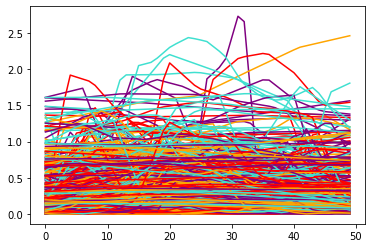

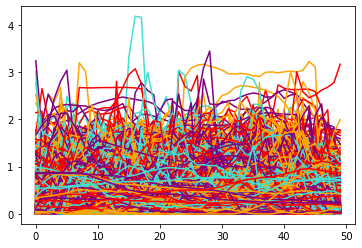

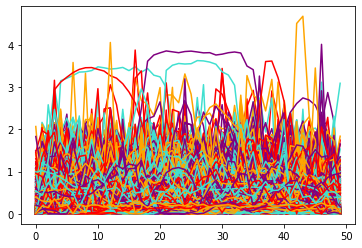

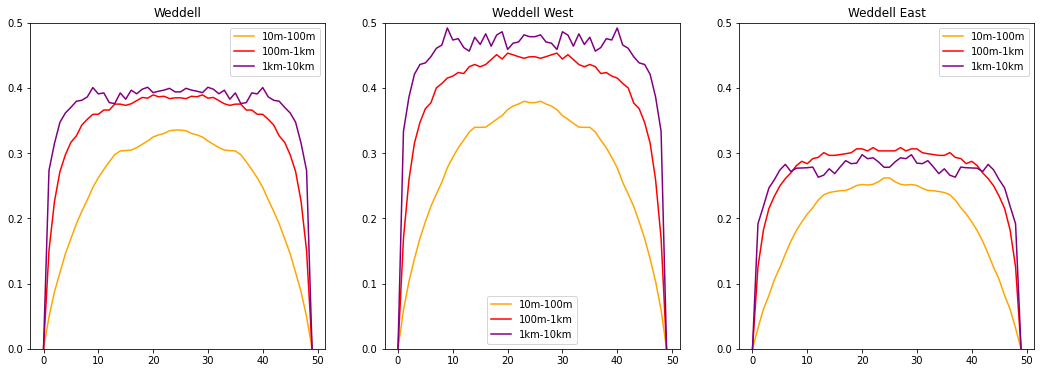

In [140]:

print(floe_chord_lengths)
print(np.shape(floe_chord_lengths))
print(np.shape(floe_profiles))

ind10_100 = np.where((floe_chord_lengths>10)&(floe_chord_lengths<=100))[0]
#xxx=[idx for idx in range(len(floe_chord_lengths)) if floe_chord_lengths[idx] > 10 and floe_chord_lengths[idx] <= 100]
ind100_1000 = np.nonzero((floe_chord_lengths>100)&(floe_chord_lengths<=1000))[0]
ind1000 = np.nonzero(floe_chord_lengths>1000)[0]


plt.figure()
plt.plot(floe_profiles[:,ind10_100])

plt.figure()
plt.plot(floe_profiles[:,ind100_1000])

plt.figure()
plt.plot(floe_profiles[:,ind1000])

fig1 = plt.figure(figsize = (18, 6))
ax = fig1.add_subplot(1,3,1)
ax.plot(binned_profiles)
ax.legend(['10m-100m', '100m-1km', '1km-10km'])
ax.set_title(titstr)
ax.set_ylim([0,0.5])

ax = fig1.add_subplot(1,3,2)
ax.plot(binned_profiles_W)
ax.legend(['10m-100m', '100m-1km', '1km-10km'])
ax.set_title(titstr+' West')
ax.set_ylim([0,0.5])

ax = fig1.add_subplot(1,3,3)
ax.plot(binned_profiles_E)
ax.legend(['10m-100m', '100m-1km', '1km-10km'])
ax.set_title(titstr+' East')
ax.set_ylim([0,0.5])

fig1.savefig(figdir + titstr + '_profiles_basic.png',bbox_inches='tight')

2
month 1 done
3
month 2 done
5
month 4 done
month 4 done
month 4 done
month 4 done
month 4 done
month 4 done
6
month 5 done
7
month 6 done


<ipython-input-93-aab9ac37bdd0>:55: RuntimeWarning: invalid value encountered in true_divide
  return (v - vmin)  / (vmax - vmin)


8
month 7 done
9
month 8 done


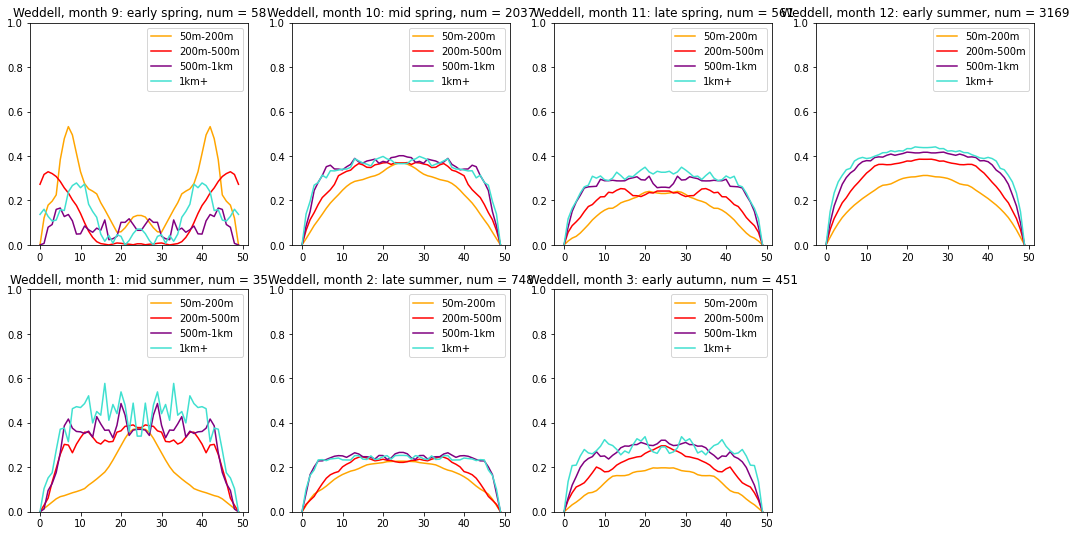

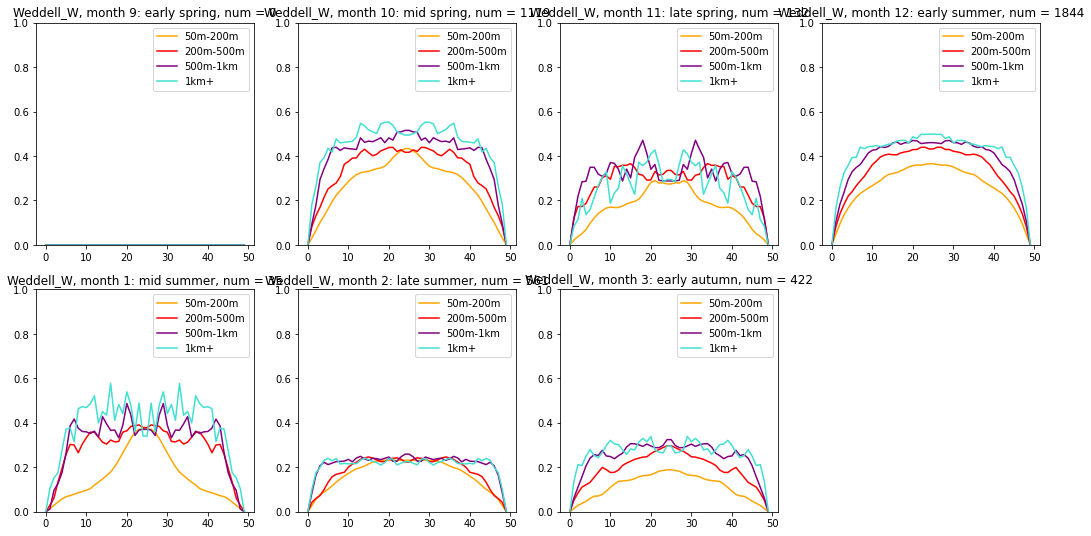

In [ ]:
fig1 = plt.figure(figsize = (18, 9))
fig1_W = plt.figure(figsize = (18, 9))
fig1_E = plt.figure(figsize = (18, 9))


fig2 = plt.figure(figsize = (18, 9))

fig3 = plt.figure(figsize = (18,6))
fig4 = plt.figure(figsize = (18,6))


ssnstr = ['mid summer','late summer','early autumn','mid autumn','late autumn',
          'early winter','mid winter','late winter','early spring','mid spring','late spring','early summer']
monthposn = [4,5,6,np.nan,np.nan,np.nan,np.nan,np.nan,0,1,2,3]
mcnt = 1

do_errorbar = 0

br = [50,200,500,1000,2000]
clist =  ['orange','red','purple','turquoise','green']
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color',clist[0:len(br)-1])))

ax3_1 = fig3.add_subplot(1,4,1)
ax3_2 = fig3.add_subplot(1,4,2)
ax3_3 = fig3.add_subplot(1,4,3)
ax3_4 = fig3.add_subplot(1,4,4)

jetmap = plt.get_cmap('jet')
mcol = jetmap(np.linspace(0,1,8))

binstrs =['50m-200m', '200m-500m', '500m-1km','1km+']

colnew = ['b','c','g','y','orange','r','m']
legstr = []
legnew = []

xcnt = 0
for mm in range(1,13):
    
    if (mm < 4) | (mm > 8):

        for endstr in ['','_W','_E']:
            if endstr == '':
                ## For full region
                ax = fig1.add_subplot(2,4, monthposn[mm-1]+1)
            elif endstr == '_W':
                ## For West region
                ax = fig1_W.add_subplot(2,4, monthposn[mm-1]+1)
            elif endstr == '_E':
                ## For East region
                ax = fig1_E.add_subplot(2,4, monthposn[mm-1]+1)
            else:
                print('unknown end string: exiting')
                import sys
                sys.exit()
            these_profiles = eval('floe_profiles'+endstr+'_orig')[eval('floe_months_prof'+endstr)==mm]*1
            n1 = 50
            n2 = int(len(these_profiles)/n1)    
            these_profiles = np.transpose(np.reshape(these_profiles,(n2,n1)) )      

            binned_profiles,binned_profiles_std = get_size_binned_profiles(these_profiles,
                                eval('floe_chord_lengths'+endstr)[eval('floe_months_fb'+endstr)==mm],bin_ranges=br)
            num_profs = len(eval('floe_chord_lengths'+endstr)[eval('floe_months_fb'+endstr)==mm])

            xval = np.arange(0,50)
            ax.plot(xval,binned_profiles)
            if do_errorbar:
                ax.plot(xval,binned_profiles+binned_profiles_std,linestyle='--')
                ax.plot(xval,binned_profiles-binned_profiles_std,linestyle='--')
                for nn in range(0,np.shape(binned_profiles)[1]):
                    ax.fill_between(xval,binned_profiles[:,nn],binned_profiles[:,nn]+binned_profiles_std[:,nn],alpha=0.1)
                for nn in range(0,np.shape(binned_profiles)[1]):
                    ax.fill_between(xval,binned_profiles[:,nn],binned_profiles[:,nn]-binned_profiles_std[:,nn],alpha=0.1)
            ax.legend(binstrs)
            #ax.legend(['10m-100m', '100m-1km', '1km-10km'])

            ax.set_ylim([0,1])
            ax.set_title(titstr+endstr+', month '+str(mm)+': '+ssnstr[mm-1]+', num = '+str(num_profs))

        ax3_1.plot(xval,binned_profiles[:,0],color=mcol[monthposn[mm-1],:])
        ax3_2.plot(xval,binned_profiles[:,1],color=mcol[monthposn[mm-1],:])
        ax3_3.plot(xval,binned_profiles[:,2],color=mcol[monthposn[mm-1],:])
        ax3_4.plot(xval,binned_profiles[:,3],color=mcol[monthposn[mm-1],:])
        
        ax3_1.set_title('profiles, '+binstrs[0])
        ax3_2.set_title('profiles, '+binstrs[1])
        ax3_3.set_title('profiles, '+binstrs[2])
        ax3_4.set_title('profiles, '+binstrs[3])
        
        xcnt = xcnt + 1
        
        legstr = np.append(legstr,'m'+str(mm))
        
        ax2 = fig2.add_subplot(2,4, monthposn[mm-1]+1)
        ax2.hist(floe_chord_lengths[floe_months_fb==mm],np.arange(50,2000,50))
        ax2.set_title(titstr+', month '+str(mm)+': '+ssnstr[mm-1]+', num = '+str(num_profs))

        mcnt = mcnt + 1
        if mm == 3:
            mcnt = mcnt + 1
        print(mcnt)
            
    print('month '+str(mcnt-1)+' done')
    
ax3_1.legend(legstr)
ax3_1.set_ylim([0,1])
ax3_2.set_ylim([0,1])
ax3_3.set_ylim([0,1])
ax3_4.set_ylim([0,1])


fig1.savefig(figdir + titstr + '_profiles_bymonth.png',bbox_inches='tight')
fig1_E.savefig(figdir + titstr + '_E_profiles_bymonth.png',bbox_inches='tight')
fig1_W.savefig(figdir + titstr + '_W_profiles_bymonth.png',bbox_inches='tight')
fig2.savefig(figdir + titstr + '_histograms_of_chordlength_bymonth.png',bbox_inches='tight')
fig3.savefig(figdir + titstr + '_profiles_bychordlength.png',bbox_inches='tight')


(352950,)
(352950,)
(352950,)
(352950,)
(352950,)
(352950,)
(352950,)


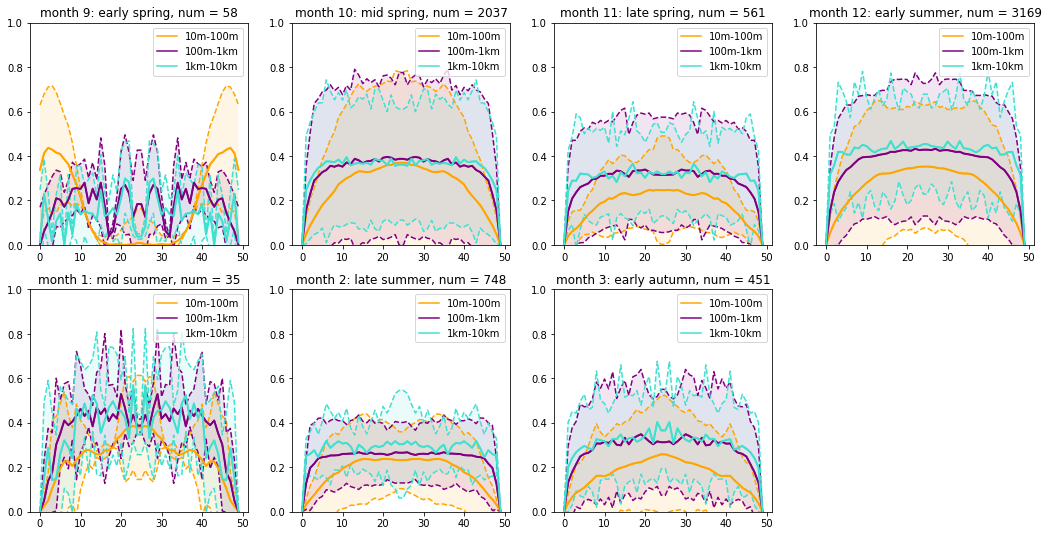

In [91]:
fig1 = plt.figure(figsize = (18, 9))

ssnstr = ['mid summer','late summer','early autumn','mid autumn','late autumn',
          'early winter','mid winter','late winter','early spring','mid spring','late spring','early summer']
monthposn = [4,5,6,np.nan,np.nan,np.nan,np.nan,np.nan,0,1,2,3]
mcnt = 1

from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['orange','purple','turquoise'])))

for mm in range(1,13):
    
    if (mm < 4) | (mm > 8):

        ax = fig1.add_subplot(2,4, monthposn[mm-1]+1)
        #plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])
        print(np.shape(floe_profiles_orig))
        these_profiles = floe_profiles_orig[floe_months_prof==mm]*1
        n1 = 50
        n2 = int(len(these_profiles)/n1)    
        these_profiles = np.transpose(np.reshape(these_profiles,(n2,n1)) )      

        binned_profiles,binned_profiles_std = get_size_binned_profiles(these_profiles,floe_chord_lengths[floe_months_fb==mm])
        num_profs = len(floe_chord_lengths[floe_months_fb==mm])

        xval = np.arange(0,50)
        plt.plot(xval,binned_profiles)
        plt.plot(xval,binned_profiles+binned_profiles_std,linestyle='--')
        plt.plot(xval,binned_profiles-binned_profiles_std,linestyle='--')
        for nn in range(0,np.shape(binned_profiles)[1]):
            plt.fill_between(xval,binned_profiles[:,nn],binned_profiles[:,nn]+binned_profiles_std[:,nn],alpha=0.1)
        for nn in range(0,np.shape(binned_profiles)[1]):
            plt.fill_between(xval,binned_profiles[:,nn],binned_profiles[:,nn]-binned_profiles_std[:,nn],alpha=0.1)
        plt.legend(['10m-100m', '100m-1km', '1km-10km'])
        plt.plot(xval,binned_profiles,linewidth=2)
        
        ax.set_ylim([0,1])
        ax.set_title('month '+str(mm)+': '+ssnstr[mm-1]+', num = '+str(num_profs))
        mcnt = mcnt + 1
        if mm == 3:
            mcnt = mcnt + 1